# CS 613 - Natural Language Processing

## Assignment 1

### 1) 
In this part I will read all the tweets and clean them using regex and then apply the tokenizers. Using regex I will remove all the links and smileys, which are not useful. (If we consider links as tokens it will not affect the values calculated much). Then, I will use tweet tokenizer followed by regex tokenizer to get my tokens.

In [47]:
# Libraries
from nltk.tokenize import regexp_tokenize, TweetTokenizer
import re, csv
from collections import defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [48]:
# Utility Functions for removing links and smileys#

def link_remover(data):
    p = re.compile('(http|pic.).*?(¦|\s|\n|$)')
    return p.sub('', data)

def smiley_remover(data):
    p = re.compile('(:|;|<)[-\]*[a-zA-Z0-9(){}]')
    return p.sub('', data)

In [49]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True) # this is the tweet_tokenizer
word_tokens = [] # will store all the tokens

with open("./tweets-dataset.csv", "r", encoding='utf-8') as dataset:
    data = csv.reader(dataset)
    column_name = 0 # this is just to eliminate the first row, which is actually the column heading.
    for tweet in data: 
        if column_name==0: 
            column_name = 1
            continue
        cleaned_tweet = smiley_remover(link_remover(tweet[0])) # Cleaned text 
        tweet_tokenized_tweet = " ".join(tknzr.tokenize(cleaned_tweet.lower())) # tweet tokenized, and then joined back as a single string
        word_tokens += list(filter(lambda s: s != "'", regexp_tokenize(tweet_tokenized_tweet, pattern="[a-zA-Z']+")))
         
word_types = set(word_tokens) # All the types

TTR = len(word_types)/len(word_tokens) 
print("No. of Tokens:", len(word_tokens))
print("No. of Types:", len(word_types))
print("TTR:", TTR) 

No. of Tokens: 293161
No. of Types: 32422
TTR: 0.1105945197348897


### 2) Plotting Zipf's law

#### i) Meaning Law: The number of meanings m of a word obeys the law -
\begin{equation}
    m \: \propto \: \sqrt{f}
\end{equation}
where, f is the frequency of that word.

#### ii) Length Law: Word frequency is inversely proportional to their length
\begin{equation}
    l \: \propto \: \frac{1}{f}
\end{equation}


Now, lets preprocess some required stuff.


In [50]:
freq_dict = defaultdict(int) # Dictionary of frequencies of tokens
for token in word_tokens:
    freq_dict[token] += 1
freq_list = sorted(freq_dict.items(), key=itemgetter(1)) # List of (word,freq) pair sorted according to freq

first, for meanings law, I am selecting some words covering a range of frequencies and found their number of meanings using wordnet.

In [51]:
from nltk.corpus import wordnet as wn
meanings = defaultdict(int)
for w in word_types:
    ms = len(set(wn.synsets(w)))
    meanings[w] = ms

selected_words = ['hangover','flowers','female','through','full','bad','good','last','see','officials']
pairs = sorted([(meanings[i], freq_dict[i], i) for i in selected_words], key=itemgetter(1))
print(pairs)

meanings = [i[0] for i in pairs]
frequencies = [i[1] for i in pairs]

[(2, 1, 'officials'), (3, 4, 'hangover'), (4, 5, 'flowers'), (5, 10, 'female'), (7, 15, 'through'), (13, 52, 'full'), (17, 88, 'bad'), (21, 136, 'last'), (25, 168, 'see'), (27, 227, 'good')]


now, for length law, for every length available I will calculate the no. of words having that length in the corpus. 

In [52]:
length_dict = defaultdict(int) # length mapped to freqs
for i in freq_dict:
    length_dict[len(i)] += freq_dict[i]

selected_words_1 = ['hangover','flowers','female','full','bad','see','officials', 'trust', 'my']
length_freq = sorted([(len(i), freq_dict[i],i) for i in selected_words_1], key=itemgetter(1)) # (length, freq) pair sorted according to length
lengths = [i[0] for i in length_freq]
freqs = [i[1] for i in length_freq]
print(length_freq)

[(9, 1, 'officials'), (8, 4, 'hangover'), (7, 5, 'flowers'), (6, 10, 'female'), (5, 17, 'trust'), (4, 52, 'full'), (3, 88, 'bad'), (3, 168, 'see'), (2, 421, 'my')]


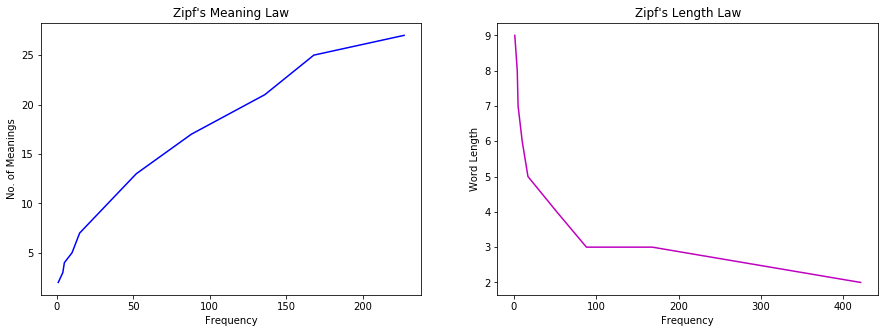

In [53]:
# Plotting
plt.rcParams["figure.figsize"] = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(frequencies,meanings, 'b') # Zipf's law of meanings
ax1.set_title("Zipf's Meaning Law")
ax1.set_ylabel('No. of Meanings')
ax1.set_xlabel('Frequency')
ax2.plot(freqs,lengths, 'm') # Zipf's law of lengths
ax2.set_title("Zipf's Length Law")
ax2.set_ylabel('Word Length')
ax2.set_xlabel('Frequency')
plt.show()

As we can see, both the above plots resembles the conditions of Zipf's law. Therefore, Zipf's law holds true for this dataset.

### 3) Heap's Law

Let $|V|$ be the size of the vocabulary and $N$ be the number of tokens, then
\begin{equation}
    |V| = KN^{\beta}
\end{equation}
where, $K \approx 10-100$ and $\beta \approx 0.4-0.6$

In [54]:
ntokens = [i for i in range(1,len(word_tokens)+1)] # No. of tokens
modV = [0]*len(word_tokens) # Vocabulary size
vocab = set() # Vocabulary, we will keep adding into this and update the above.

for i in range(len(word_tokens)):
    vocab.add(word_tokens[i])
    modV[i] = len(vocab)

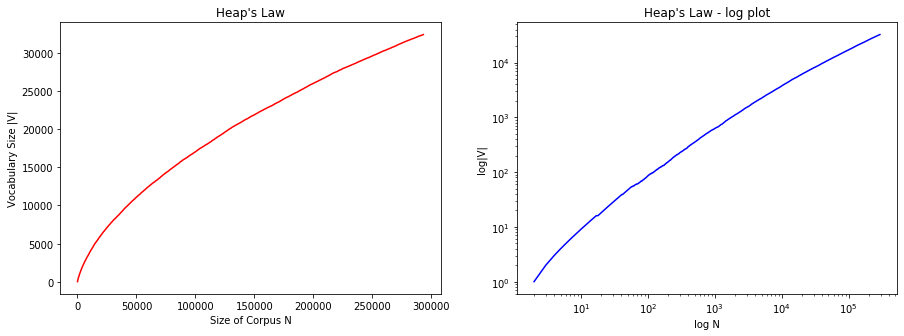

In [55]:
#Plotting
plt.rcParams["figure.figsize"] = (15,5)
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(ntokens, modV, 'r')
ax1.set_title("Heap's Law")
ax1.set_ylabel('Vocabulary Size |V|')
ax1.set_xlabel('Size of Corpus N')
ax2.plot(ntokens[1:], modV[1:], 'b')
ax2.set_xscale('log', basex=10)
ax2.set_yscale('log', basey=10)
ax2.set_title("Heap's Law - log plot")
ax2.set_ylabel('log|V|')
ax2.set_xlabel('log N')
plt.show()

In [56]:
# Estimating beta and k. I will use log plots and find a best fit line.
x, y = np.log(ntokens), np.log(modV)
beta,logk = np.polyfit(x,y,1) 
print("beta:", beta)
print("K:", np.exp(logk))

beta: 0.6544538577406211
K: 8.940769966382096


The constants $\beta = 0.6545$ and $K = 8.9407$ are close to the conditions required for Heap's law. Therefore, Heap's law is verified.